<h1 style="color:#b10043"> <strong> Modelisation de signaux aléatoires - Projet </strong> </h1>  

<small>     
Marco Guzzo, <br> 
Laura Luzzi, <br>  
Mathieu Guerquin-Kern, <br> 
Inbar Fijalkow <br>

vers. 2025 </small>

**Binôme :**

- Etudiant 1   
- Etudiant 2  

***  
## Sommaire
- [Contexte](#contexte)
    - [Un modèle source/filtre pour la voix](#c-modele)
    - [Une stationnarité limitée dans le temps](#c-stat)
    - [Schéma d'analyse et de synthèse à suivre](#c-schema)
- [Séance 1 : Estimation de l'autocorrélation](#seance1)
    - [Des données sur lesquelles travailler](#s1-gen-sig)
    - [Estimateur biaisé de l'autocorrélation](#s1-autocorr-b)
    - [Estimateur non-biaisé de l'autocorrélation](#s1-autocorr-nb)
    - [Etablissement d'un critère pour le caractère voisé](#s1-voise)
    - [Pour aller plus loin](#s1-further)
- [Séance 2 : Analyse spectrale](#seance2)
    - [Deux approches pour un même estimateur (ou presque)](#s2-estim)
    - [Fiabilité de l'estimation spectrale](#s2-wk)
    - [Choix d'une fenêtre temporelle](#s2-fenetrage)
- [Séance 3 : Prédiction linéaire](#seance3)
    - [Résolution des équations de Yule-Walker](#s3-yule-walker)
    - [Réalisations de processus connus](#s3-process)
    - [Sons voisés et non voisés](#s3-v-nv)
- [Séance 4 : Codage, décodage et effets sur la parole](#seance4)
    - [Analyse d'un tronçon](#s4-analyse)
    - [Synthèse d'un tronçon](#s4-synthese)
    - [Traitement d'un signal et effets](#s4-tns-effets)

$\quad$  
***

Les quatre séances de TP de majeure de Signal du semestre 7 (« Modélisation des Signaux Aléatoires») prennent la forme d’un projet unique réalisé dans l’environnement Jupyter Notebook. Les fichiers nécessaires sont accessibles sur Moodle.  
Vous ajouterez des cellules de type "Code" pour toute la partie programmation et de type "Markdown" pour la partie commentaire.

L'évaluation se fera sur la base du **travail réalisé en séance**. Pour cela vous préviendrez votre professeur lorsque vous atteindrez un <span style="color:blue"> **Checkpoint** </span>.  

Avant de vous lancer dans le codage, rappelez sur une feuille la formule de la fonction que vous allez programmer.

On préfèrera préciser ici en amont que toute figure se doit :
- d'avoir un titre
- d'avoir des axes labélisés
- d'avoir une légende (si plusieurs courbes)
- d'être assortie de commentaires 

In [2]:
# À lancer la première fois pour s'assurer que toutes les bibliothèques sont bien installées
# !pip install -r requirements.txt

In [3]:
# À lancer en début de chaque relance du noyau Python

import matplotlib.pyplot as plt  # permet de faire de l'affichage
import scienceplots  # un addon du précédent pour des plus jolies figures

plt.style.use(["science", "notebook"])

import numpy as np  # pour tout ce qui est calcul vectoriel
import numpy.random as rd  # pour toute la partie aléatoire
import scipy.signal as s  # pour ce qui est filtrage
import scipy.linalg as sp
from scipy.fft import fft, fftfreq, ifft  # pour la partie fréquentielle
import soundfile as sf  # pour la gestion des fichiers audio
import librosa as lb  # certains outils de traitement du signal pour la musique
import IPython.display as ipd  # affichage inline des éléments (notamment audio ici)

***

<a id="contexte"></a>
## Contexte

> $\quad$  
> L’objectif de ce projet est de mettre en oeuvre une chaîne de codage et décodage de la voix humaine utilisant le linear predictive coding (codage par prédition linéaire). Une telle chaîne se retrouve dans des applications de transmission de la parole économes en bande passante (voir normes [GSM 06.10](https://en.wikipedia.org/wiki/Full_Rate) ou [LPC-10/FS-1015](https://en.wikipedia.org/wiki/FIPS_137)), où l’objectif est d’extraire les caractéristiques minimales du signal à transmettre (étape d’analyse du codeur) et d’être capable, à la réception, de synthétiser (codeur) un signal fidèle à l’original.  
> La maîtrise des étapes d’analyse et de synthèse ouvre également la voie à des applications créatives où un effet est appliqué à la parole en suivant trois étapes :
> - Analyse des caractéristiques de la parole.
> - Manipulation de ces caractéristiques pour obtenir un effet désiré (par exemple, changement de fréquence).
> - Synthèse de la parole à partir des caractéristiques modifiées. 
>
> On comparera les signaux réels et synthétiques avec les outils de traitement du signal (autocorrélation, spectre) et à l’oreille.  
> $\quad$

<a id="c-modele"></a>
### Un modèle source/filtre pour la voix

Des modèles plus ou moins complexes des mécanismes de production de la parole peuvent être établis.

Le plus simple d'entre eux, illustré en *Figure 1* consiste à considérer que *le signal représentant la parole est issu d'un filtre linéaire, modélisant le conduit vocal, qui est excité par une source indépendante, modélisant l'expiration passant à travers la glotte*.   
Cette source glottique peut prendre deux formes :
- **voisée** : correspondant à des vibrations vocales, modélisée par une impulsion périodique à phase aléatoire (c'est par exemple le cas pour les voyelles, ainsi que de 'b', 'd' et 'z'),
- **non voisée** : correspondant à un écoulement turbulent du flux d'air expiré, modélisé par un bruit blanc (c'est par exemple le cas pour 'p', 't', 's' et 'ch').
Cette modélisation est particulièrement utile pour élaborer des outils de compression de la parole : la parole n'est plus représentée comme une suite d'échantillons, mais directement à partir d'une suite de modèles source/filtre. 

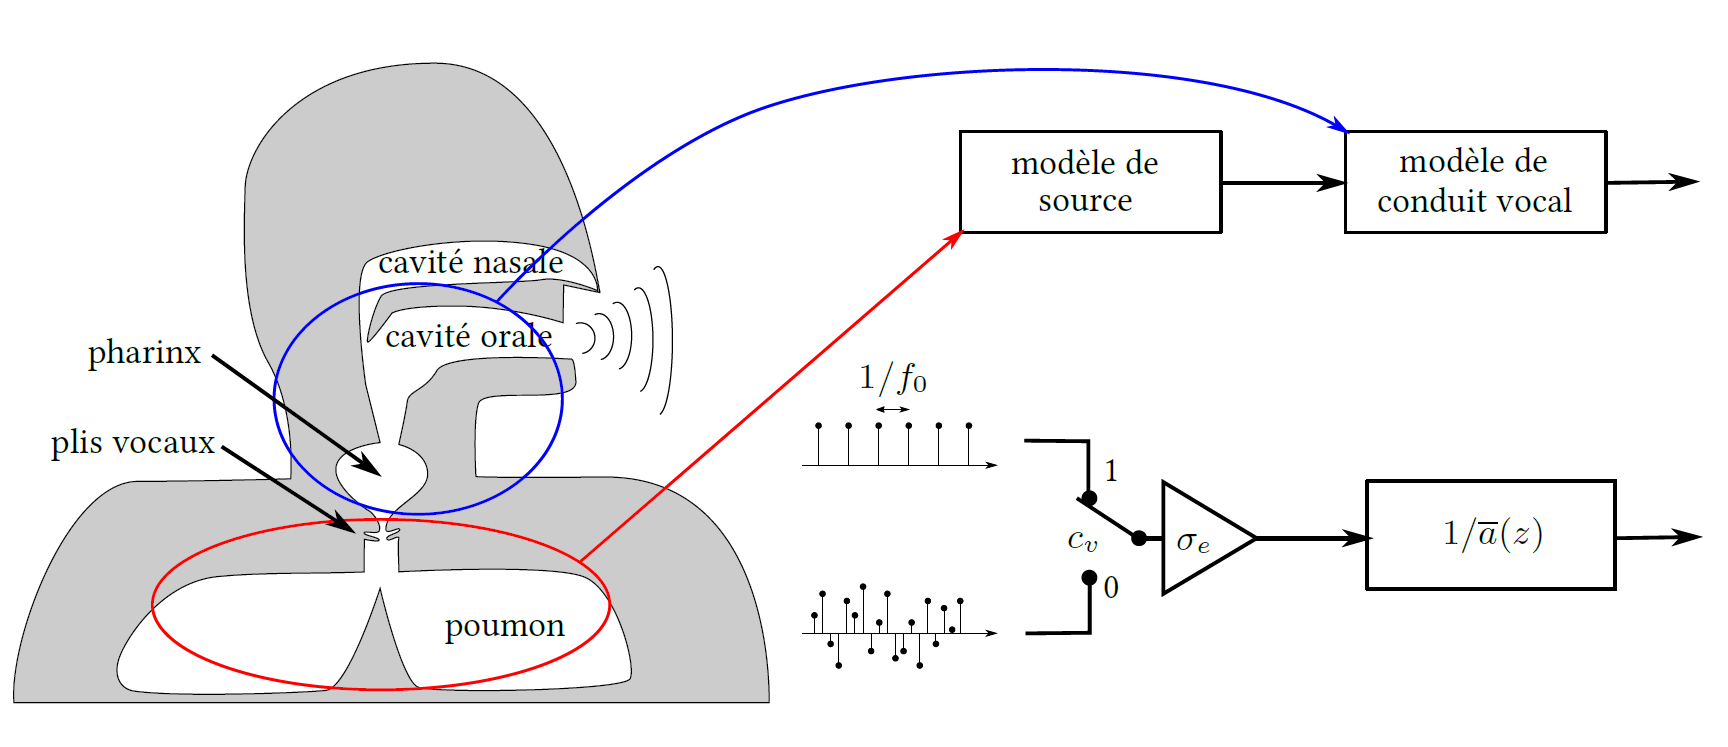

*Figure 1* - Illustration du modèle source/filtre.  

Dans ce contexte, la chaîne de traitement de la parole comprend deux étapes :
- une partie codage (analyse) dont le but est d'analyser le signal de parole pour en déduire une représentation sous forme de modèles source/filtre dont les paramètres sont transmis. Ainsi le débit d'information est réduit (compression).
- une partie décodage (synthèse) permettant de reconstruire le signal de parole à partir de la seule donnée des modèles source/filtre.  

Pour en savoir plus sur l'anatomie de l'appareil vocal et sa modélisation, on peut se rapporter respectivement aux [chapitres 1 et 2 de la thèse de Thomas Hézard (2014)](https://hal.archives-ouvertes.fr/tel-00933070/document).

<a id="c-stat"></a>
### Une stationnarité limitée dans le temps

Le modèle source/filtre est satisfaisant pour expliquer l'origine des sons constituant la parole (voir *Figure 2*). Alors, on peut établir des modèles aléatoires stationnaires aux ordres 1 et 2 selon que le son est voisé ou non. Néanmoins, au cours du temps, les caractéristiques du modèle sont amenées à évoluer, ce qui rompt la stationnarité.  
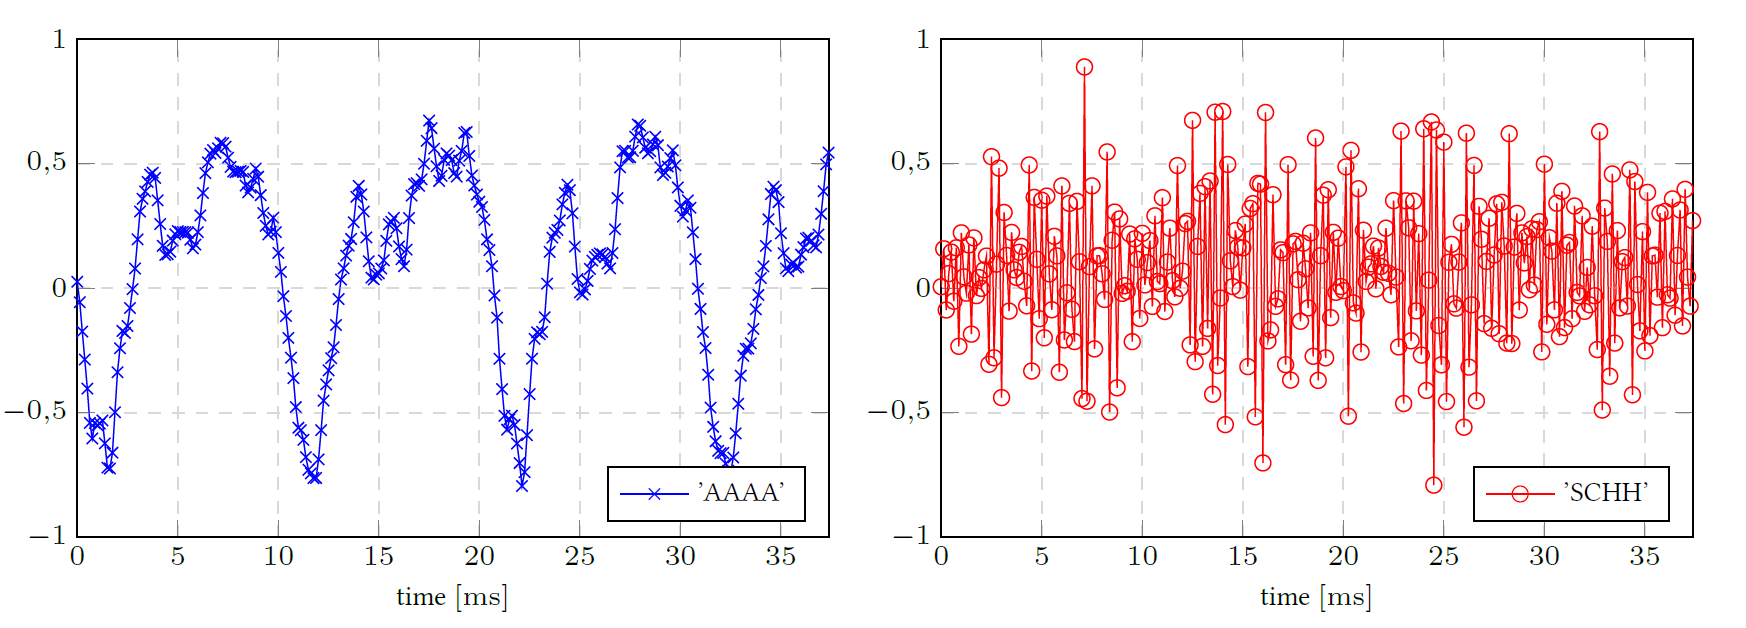

*Figure 2* - Évolutions temporelles de son voisé (à gauche) et non voisé (à droite). 

Le **son voisé** présente une pseudo-périodicité, il est très structuré. On le modélise bien avec une **impulsion périodique filtrée**. À l'inverse, le **son non voisé** est peu structuré (régulier) : il se modélise bien avec un **bruit blanc filtré**.

On considère généralement que **pour des périodes de l'ordre de 20 à 30 ms, l'hypothèse de stationnarité du signal de parole est satisfaite**.

Dans le cadre de ce projet, nous vous proposons de travailler avec une fréquence d'échantillonnage **$F_{e} = 10 \ \text{kHz}$**, suffisante pour le signal de parole, en analysant le signal par tronçons de **256 échantillons**.

<a id="c-schema"></a>
### Schéma d'analyse et de synthèse à suivre

Dans ce projet, nous vous proposons de suivre le schéma présenté en *Figure 3*. Il se décompose en deux étapes :

**L'analyse :**  
Cette première étape de la chaîne de traitement du signal de parole a pour buts :

- de découper le signal de parole en tronçons d'analyse de $N=256$ échantillons chacune,
- de déterminer, pour chaque tronçon, le filtre prédicteur optimal de $M$ paramètres $\mathbf{a}_{\text {opt }}$, le caractère voisé ou non $c_{v}$ (booléen) du tronçon et les caractéristiques du signal d'excitation : variance du signal d'excitation $\sigma_{e}^{2}$ et fréquence fondamentale $f_{0}$ (pitch) de la série d'impulsions si le son est voisé. Si le son est non voisé, le signal d'excitation, modélisé
par un bruit blanc gaussien, pourra être correctement synthétisé par la seule donnée de la variance $\sigma_{e}^{2}$.
- le codage de chaque tronçon se résume donc à $M+3$ paramètres (au lieu de $N=256$ échantillons) : les $M$ coefficients de $\mathbf{a}_{\text {opt }}, c_{v}, \sigma_{e}$ et $f_{0}$.

**La synthèse :**   
La seconde étape de la chaîne de traitement consiste à reconstituer le signal de parole tronçon par tronçon : connaissant pour chaque tronçon le type d'excitation, sa puissance, les coefficients du filtre $\operatorname{AR}(M)$, il suffit alors de générer une excitation et d'effectuer l'opération de filtrage idoine.

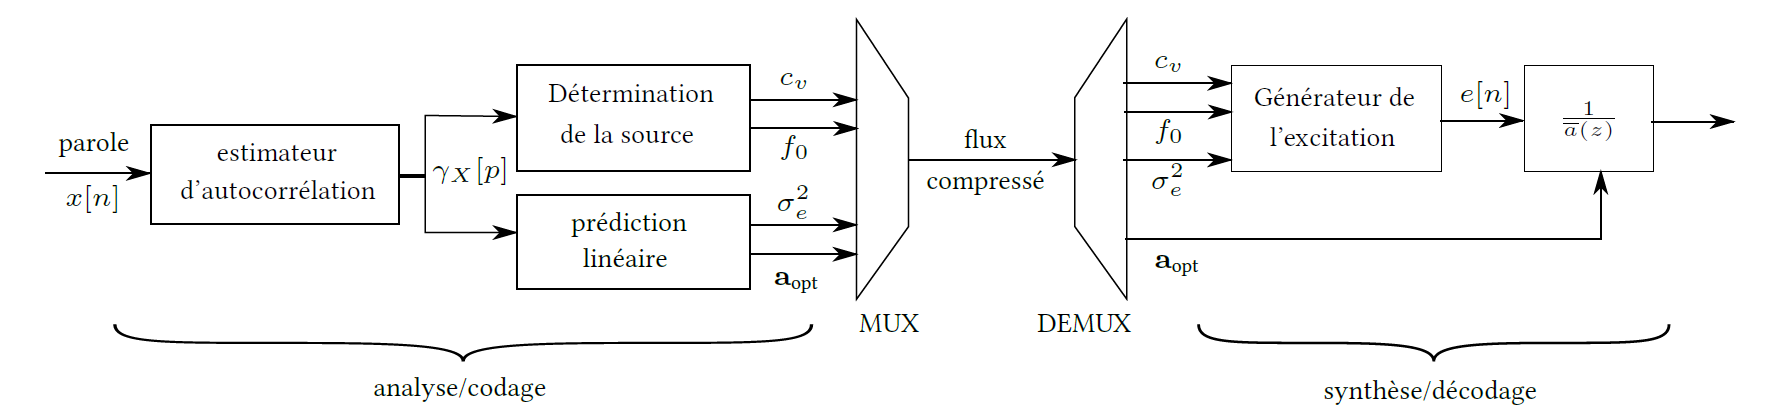  

*Figure 3* - Codage / Décodage du signal de parole.

***

<a id="seance1"></a>
## Séance 1 : Estimation de l'autocorrélation

> $\quad$  
> **Objectifs de séance :**   
> - Découverte du sujet du projet  
> - Estimation fiable de l'autocorrélation  
> - Critérisation de l'aspect voisé d'un son    
> $\quad$

<a id="s1-gen-sig"></a>
### Des données sur lesquelles travailler

Dans un premier temps, **il peut être intéressant** de tester vos estimateurs à l'aide de réalisations de processus dont vous connaissez l'autocorrélation : bruit blanc gaussien (voir `numpy.random.randn`), $\operatorname{AR}(1)$ (voir `scipy.signal.lfilter`), sinusoïde à phase aléatoire (voir `numpy.sin`).

Dans un second temps, on vous fournit une archive contenant plusieurs fichiers au format flac correspondant à des sons de nature voisée et non voisée. Pour récupérer les signaux et fréquences d'échantillonnage correspondant à ces fichiers, voir la fonction `soundfile.read`. On pourra jouer le fichier audio directement dans le notebook en utilisant la fonction `IPython.display.Audio`.

Réaliser un bruit blanc gaussien de variance $\sigma_b^2$ donnée.

In [4]:
N = 256
sigma_b = 2.0
bruit_blanc = np.sqrt(sigma_b**2) * np.random.randn(N)

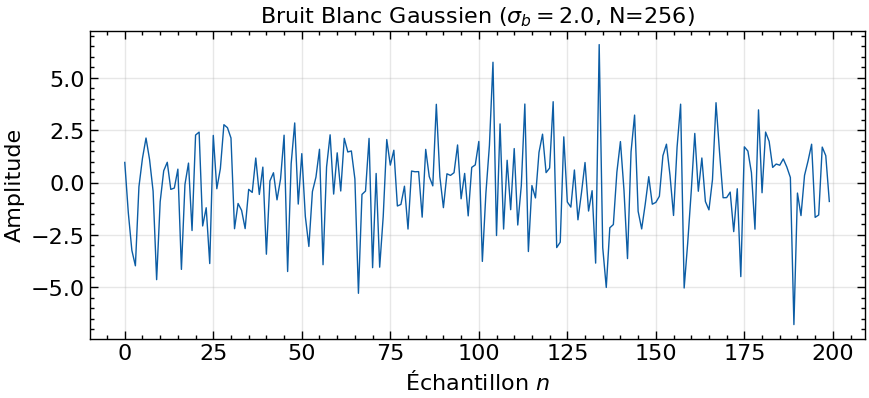

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(bruit_blanc[:200], linewidth=1)
ax.set_xlabel('Échantillon $n$')
ax.set_ylabel('Amplitude')
ax.set_title(f'Bruit Blanc Gaussien ($\\sigma_b = {sigma_b:.1f}$, N={N})')
ax.grid(True, alpha=0.3)
plt.savefig('figures/bruit_blanc_signal.png', dpi=300, bbox_inches='tight')
plt.show()

$\color{blue}\diamond$ <span style="color:blue"> **Checkpoint 1 :** </span> Réaliser un processus $\operatorname{AR}(1)$ avec un paramètre $a$ et une puissance d'innovation $\sigma^2$ donnés.

In [6]:
a = 0.8
sigma_e = 2
# innovation = sigma_e * np.random.randn(N) # Ce bruit blanc gaussien centré et de variance 4 est ici l'innovation
innovation = bruit_blanc
ar1 = s.lfilter([1], [1, -a], innovation)

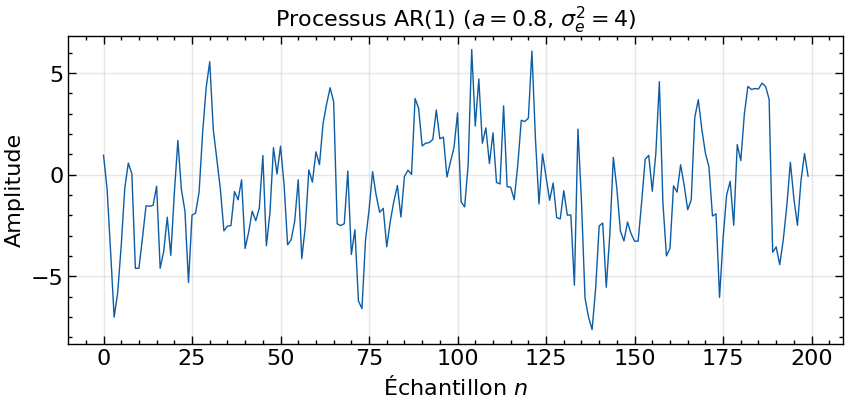

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(ar1[:200], linewidth=1)
ax.set_xlabel('Échantillon $n$')
ax.set_ylabel('Amplitude')
ax.set_title(f'Processus AR(1) ($a = {a}$, $\\sigma_e^2 = {sigma_e**2}$)')
ax.grid(True, alpha=0.3)
plt.savefig('figures/ar1_signal.png', dpi=300, bbox_inches='tight')
plt.show()

$\color{blue}\diamond$ <span style="color:blue"> **Checkpoint 2 :** </span> Réaliser une sinusoïde à phase aléatoire de fréquence réduite $\nu_0$ et d'amplitude $A$ données.

In [8]:
nu_0 = 0.1
A = 3.0
phi = 2 * np.pi * np.random.rand()
n = np.arange(N)
sinusoide = A * np.sin(2 * np.pi * nu_0 * n + phi)

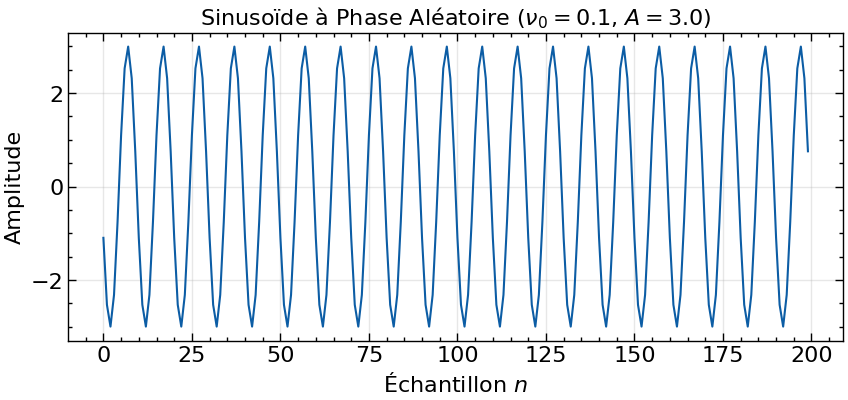

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(sinusoide[:200], linewidth=1.5)
ax.set_xlabel('Échantillon $n$')
ax.set_ylabel('Amplitude')
ax.set_title(f'Sinusoïde à Phase Aléatoire ($\\nu_0 = {nu_0}$, $A = {A}$)')
ax.grid(True, alpha=0.3)
plt.savefig('figures/sinusoide_signal.png', dpi=300, bbox_inches='tight')
plt.show()

<a id="s1-autocorr-b"></a>
### Estimateur biaisé de l'autocorrélation

Écrire la fonction décrite de la manière suivante :

In [10]:
def biaisedCrossCorr(x: np.ndarray, pmax: int):
    """Computation of the biaised cross correlation of a given signal x

    Inputs
    ----------
    x : np.ndarray
        Vector of signal samples
    pmax : int
        Maximal amount of delay to be considered (optionnal, default set to len(x)-1)

    Returns
    -------
    Cx : np.ndarray
        Vector of cross correlation samples from shifts varying from 0 to pmax
    p : np.ndarray
        Vector of corresponding shifts
    """
    N = len(x)
    x = x - np.mean(x)
    Cx = np.zeros(pmax + 1)
    for delay in range(pmax + 1):
        Cx[delay] = np.sum(x[:N-delay] * x[delay:]) / N
    p = np.arange(pmax + 1)
    return Cx, p

Liste non exhaustive de questions que l'on peut se poser :

- Comment générer une réalisation de bruit blanc de variance donnée ?
- Comment générer une réalisation de processus $\operatorname{AR}(1)$ avec un paramètre $a$ et une puissance d'innovation $\sigma^{2}$ donnés ?
- Comment générer une réalisation de sinusoïde à phase aléatoire de fréquence réduite et d'amplitude données ?
- Pour quelles valeurs du retard $p$ peut-on estimer l'estimateur biaisé de l'autocorrélation ?
- Que se passe-t-il si le signal étudié contient une composante continue, traduisant un processus non centré ? Comment estimer correctement son autocorrélation ?
- La valeur d'autocorrélation estimée prise pour un décalage $p=0$ est-elle en accord avec ce que renvoie la fonction `numpy.var` ?
- Pour des processus dont on connait l'autocorrélation théorique, cet estimateur biaisé semble-t-il converger quand le nombre d'échantillons du signal devient grand ?
- Peut-on observer l'effet du biais avec certains exemples ?
- Cet estimateur biaisé est-il plutôt adéquat pour les sons voisés ou pour les sons non voisés ?  

$\color{blue}\diamond$ <span style="color:blue"> **Checkpoint 3 :** </span> Tester votre fonction sur les signaux artificiels réalisés dans la section précédente et discuter les résultats.

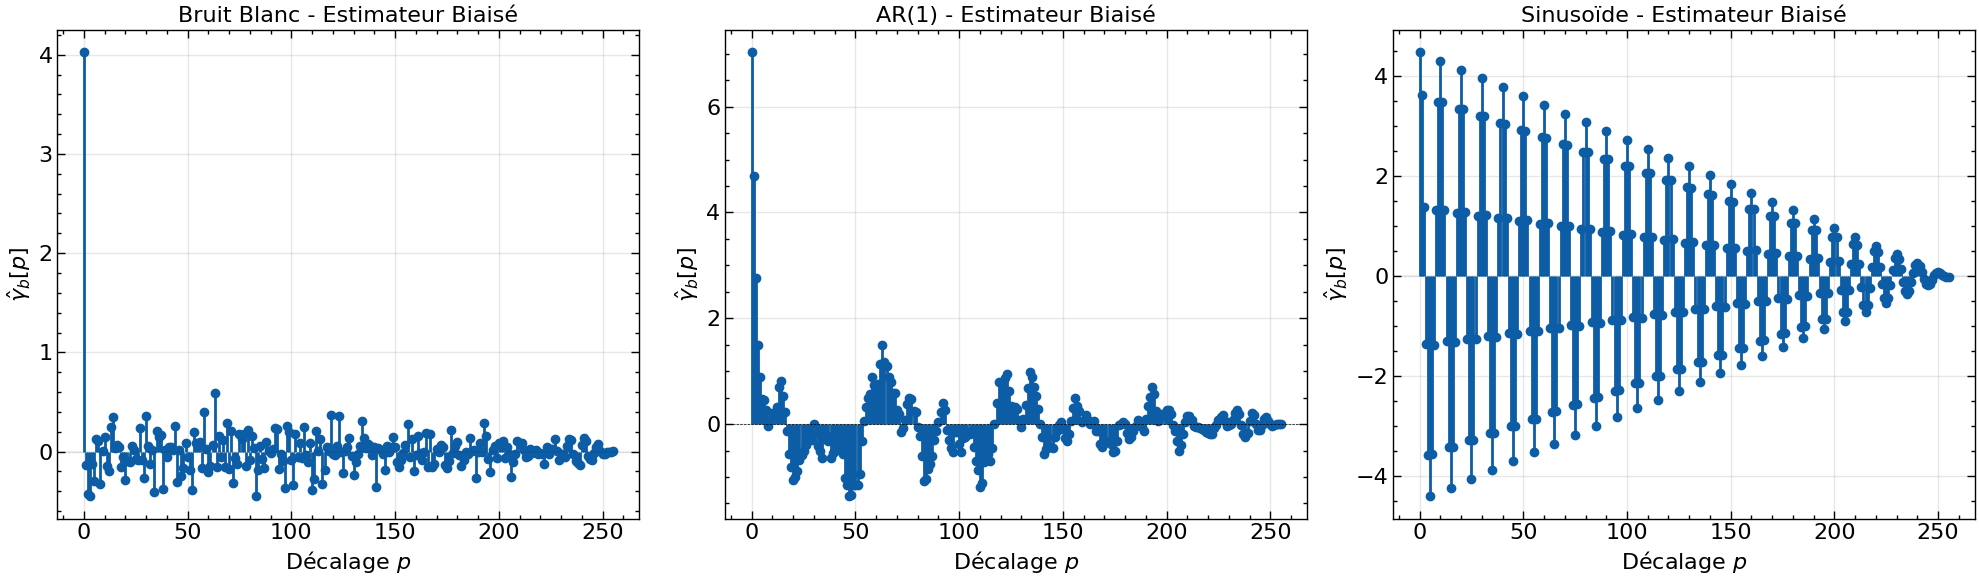

In [11]:
pmax = 255
Cx_bb, p_bb = biaisedCrossCorr(bruit_blanc, pmax)
Cx_ar, p_ar = biaisedCrossCorr(ar1, pmax)
Cx_sin, p_sin = biaisedCrossCorr(sinusoide, pmax)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

axes[0].stem(p_bb, Cx_bb, basefmt=' ')
axes[0].axhline(0, color='k', linestyle='--', linewidth=0.1)
axes[0].set_xlabel('Décalage $p$')
axes[0].set_ylabel('$\\hat{\\gamma}_{b}[p]$')
axes[0].set_title('Bruit Blanc - Estimateur Biaisé')
axes[0].grid(True, alpha=0.3)

axes[1].stem(p_ar, Cx_ar, basefmt=' ')
axes[1].axhline(0, color='k', linestyle='--', linewidth=0.5)
axes[1].set_xlabel('Décalage $p$')
axes[1].set_ylabel('$\\hat{\\gamma}_{b}[p]$')
axes[1].set_title('AR(1) - Estimateur Biaisé')
axes[1].grid(True, alpha=0.3)

axes[2].stem(p_sin, Cx_sin, basefmt=' ')
axes[2].axhline(0, color='k', linestyle='--', linewidth=0.1)
axes[2].set_xlabel('Décalage $p$')
axes[2].set_ylabel('$\\hat{\\gamma}_{b}[p]$')
axes[2].set_title('Sinusoïde - Estimateur Biaisé')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/autocorr_biaisee_tests.png', dpi=300, bbox_inches='tight')
plt.show()

In [12]:
print(f"Bruit Blanc - Variance théorique : {sigma_b**2:.4f}")
print(f"Bruit Blanc - Variance estimée (np.var) : {np.var(bruit_blanc):.4f}")
print(f"Bruit Blanc - Autocorrélation à p=0 : {Cx_bb[0]:.4f}")
print()
print(f"AR(1) - Variance théorique : {sigma_e**2 / (1 - a**2):.4f}")
print(f"AR(1) - Variance estimée (np.var) : {np.var(ar1):.4f}")
print(f"AR(1) - Autocorrélation à p=0 : {Cx_ar[0]:.4f}")
print()
print(f"Sinusoïde - Variance théorique : {A**2 / 2:.4f}")
print(f"Sinusoïde - Variance estimée (np.var) : {np.var(sinusoide):.4f}")
print(f"Sinusoïde - Autocorrélation à p=0 : {Cx_sin[0]:.4f}")

Bruit Blanc - Variance théorique : 4.0000
Bruit Blanc - Variance estimée (np.var) : 4.0267
Bruit Blanc - Autocorrélation à p=0 : 4.0267

AR(1) - Variance théorique : 11.1111
AR(1) - Variance estimée (np.var) : 7.0308
AR(1) - Autocorrélation à p=0 : 7.0308

Sinusoïde - Variance théorique : 4.5000
Sinusoïde - Variance estimée (np.var) : 4.4860
Sinusoïde - Autocorrélation à p=0 : 4.4860


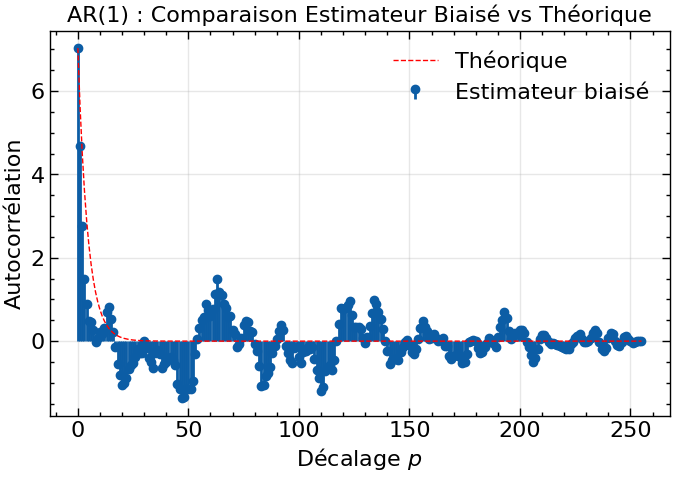

In [13]:
gamma_ar_theo = np.array([Cx_ar[0] * a**p for p in range(pmax + 1)])

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.stem(p_ar, Cx_ar, label='Estimateur biaisé', basefmt=' ')
ax.plot(p_ar, gamma_ar_theo, 'r--', linewidth=1, label='Théorique')
ax.set_xlabel('Décalage $p$')
ax.set_ylabel('Autocorrélation')
ax.set_title('AR(1) : Comparaison Estimateur Biaisé vs Théorique')
ax.legend()
ax.grid(True, alpha=0.3)
plt.savefig('figures/autocorr_biaisee_ar1_theo.png', dpi=300, bbox_inches='tight')
plt.show()

<a id="s1-autocorr-nb"></a>
### Estimateur non-biaisé de l'autocorrélation

Écrire la fonction décrite de la manière suivante :

In [14]:
def unbiaisedCrossCorr(x: np.ndarray, pmax: int):
    """Computation of the unbiaised cross correlation of a given signal x

    Inputs
    ----------
    x : np.ndarray
        Vector of signal samples
    pmax : int
        Maximal amount of delay to be considered (optionnal, default set to len(x)-1)

    Returns
    -------
    Cx : np.ndarray
        Vector of cross correlation samples from shifts varying from 0 to pmax
    p : np.ndarray
        Vector of corresponding shifts
    """
    N = len(x)
    x = x - np.mean(x)
    Cx = np.zeros(pmax + 1)
    for delay in range(pmax + 1):
        Cx[delay] = np.sum(x[:N-delay] * x[delay:]) / (N - delay)
    p = np.arange(pmax + 1)
    return Cx, p

$\color{blue}\diamond$ <span style="color:blue"> **Checkpoint 4 :** </span> Tester votre fonction sur vos signaux artificiels et discuter les résultats (on comparera notamment avec les résultats de la section précédente).

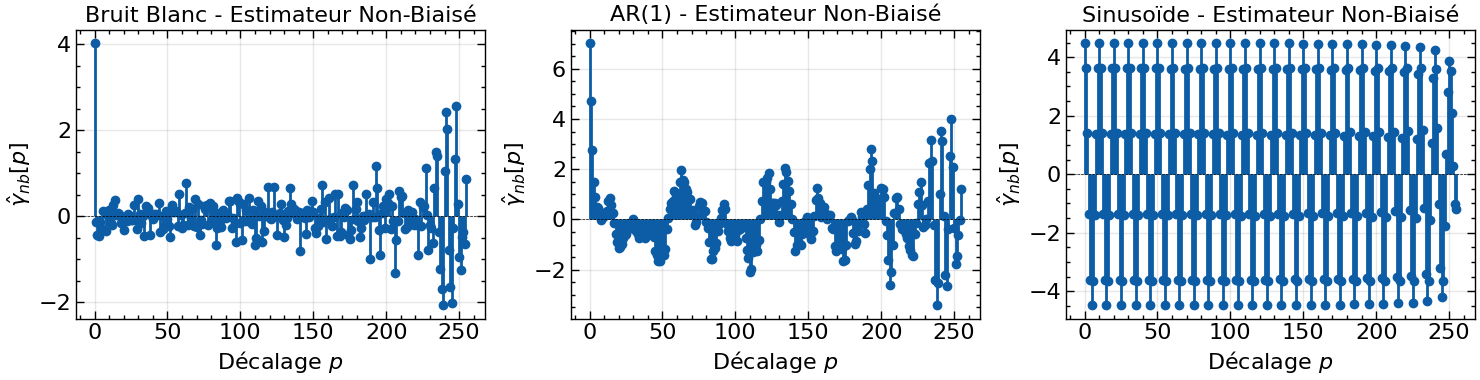

In [15]:
Cx_bb_nb, p_bb_nb = unbiaisedCrossCorr(bruit_blanc, pmax)
Cx_ar_nb, p_ar_nb = unbiaisedCrossCorr(ar1, pmax)
Cx_sin_nb, p_sin_nb = unbiaisedCrossCorr(sinusoide, pmax)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].stem(p_bb_nb, Cx_bb_nb, basefmt=' ')
axes[0].axhline(0, color='k', linestyle='--', linewidth=0.5)
axes[0].set_xlabel('Décalage $p$')
axes[0].set_ylabel('$\\hat{\\gamma}_{nb}[p]$')
axes[0].set_title('Bruit Blanc - Estimateur Non-Biaisé')
axes[0].grid(True, alpha=0.3)

axes[1].stem(p_ar_nb, Cx_ar_nb, basefmt=' ')
axes[1].axhline(0, color='k', linestyle='--', linewidth=0.5)
axes[1].set_xlabel('Décalage $p$')
axes[1].set_ylabel('$\\hat{\\gamma}_{nb}[p]$')
axes[1].set_title('AR(1) - Estimateur Non-Biaisé')
axes[1].grid(True, alpha=0.3)

axes[2].stem(p_sin_nb, Cx_sin_nb, basefmt=' ')
axes[2].axhline(0, color='k', linestyle='--', linewidth=0.5)
axes[2].set_xlabel('Décalage $p$')
axes[2].set_ylabel('$\\hat{\\gamma}_{nb}[p]$')
axes[2].set_title('Sinusoïde - Estimateur Non-Biaisé')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/autocorr_non_biaisee_tests.png', dpi=300, bbox_inches='tight')
plt.show()

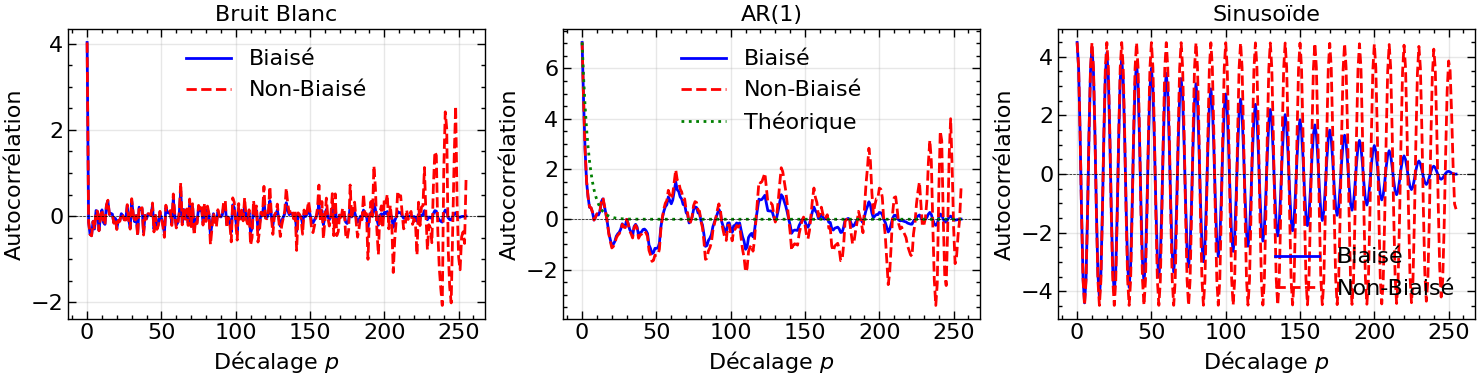

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(p_bb, Cx_bb, 'b-', label='Biaisé', linewidth=2)
axes[0].plot(p_bb_nb, Cx_bb_nb, 'r--', label='Non-Biaisé', linewidth=2)
axes[0].axhline(0, color='k', linestyle='--', linewidth=0.5)
axes[0].set_xlabel('Décalage $p$')
axes[0].set_ylabel('Autocorrélation')
axes[0].set_title('Bruit Blanc')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(p_ar, Cx_ar, 'b-', label='Biaisé', linewidth=2)
axes[1].plot(p_ar_nb, Cx_ar_nb, 'r--', label='Non-Biaisé', linewidth=2)
axes[1].plot(p_ar, gamma_ar_theo, 'g:', linewidth=2, label='Théorique')
axes[1].axhline(0, color='k', linestyle='--', linewidth=0.5)
axes[1].set_xlabel('Décalage $p$')
axes[1].set_ylabel('Autocorrélation')
axes[1].set_title('AR(1)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].plot(p_sin, Cx_sin, 'b-', label='Biaisé', linewidth=2)
axes[2].plot(p_sin_nb, Cx_sin_nb, 'r--', label='Non-Biaisé', linewidth=2)
axes[2].axhline(0, color='k', linestyle='--', linewidth=0.5)
axes[2].set_xlabel('Décalage $p$')
axes[2].set_ylabel('Autocorrélation')
axes[2].set_title('Sinusoïde')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/autocorr_comparaison_biais.png', dpi=300, bbox_inches='tight')
plt.show()

Liste non exhaustive de questions que l'on peut se poser :
- Pour des processus dont on connaît l'autocorrélation théorique, cet estimateur non biaisé semble-t-il converger quand le nombre d'échantillons du signal devient grand ? Observe-ton effectivement un biais nul ?
- Peut-on observer l'effet de la variance de l'estimateur avec certains exemples ?
- Cet estimateur non biaisé est-il plutôt adéquat pour les sons voisés ou pour les sons non voisés ?  


<a id="s1-voise"></a>
### Etablissement d'un critère pour le caractère voisé

$\color{blue}\diamond$ <span style="color:blue"> **Checkpoint 5 :** </span> Visualiser (et écouter) un signal voisé et déterminer sa pseudo-période.

In [17]:
signal_voise, Fe = sf.read('voise_ooo.flac')
print(f"Signal voisé chargé : {len(signal_voise)} échantillons, Fe = {Fe} Hz")

ipd.Audio(signal_voise, rate=Fe)

Signal voisé chargé : 1024 échantillons, Fe = 10000 Hz


Position du 2e pic : p = 23
Pseudo-période T0 = 2.30 ms
Pitch F0 = 434.8 Hz


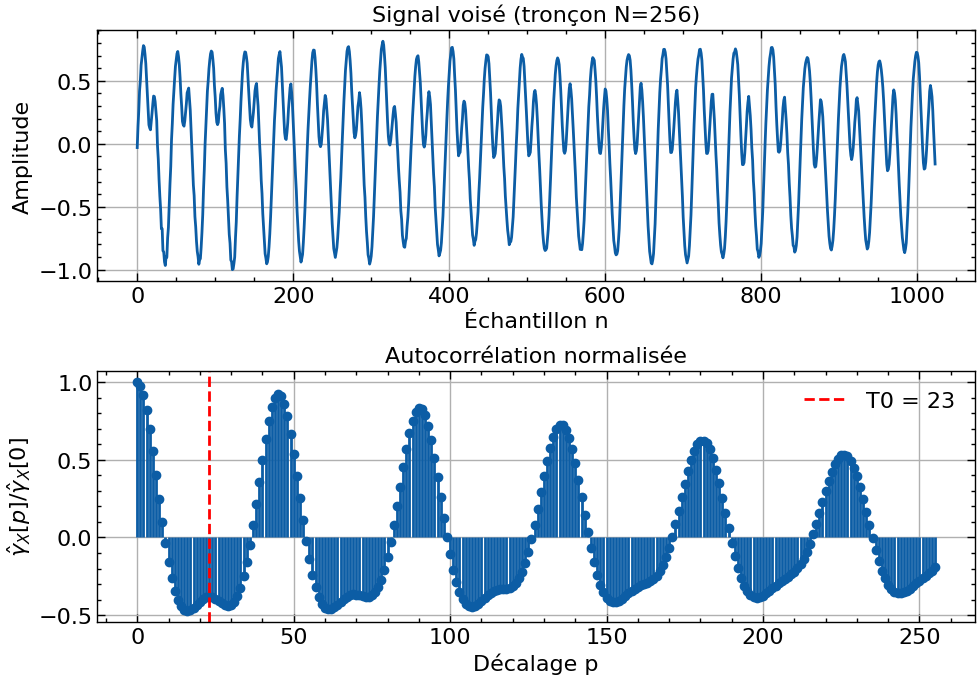

In [18]:
troncon_voise = signal_voise

Cx_voise, p_voise = biaisedCrossCorr(troncon_voise, pmax)
Cx_voise_norm = Cx_voise / Cx_voise[0]

peaks, _ = s.find_peaks(Cx_voise_norm[1:])
peaks += 1

T0_idx = peaks[0] if len(peaks) > 0 else None
T0 = T0_idx / Fe if T0_idx else None
F0 = 1 / T0 if T0 else None

print(f"Position du 2e pic : p = {T0_idx}")
print(f"Pseudo-période T0 = {T0*1000:.2f} ms")
print(f"Pitch F0 = {F0:.1f} Hz")

fig, axs = plt.subplots(2, 1, figsize=(10, 7))
axs[0].plot(troncon_voise)
axs[0].set_xlabel('Échantillon n')
axs[0].set_ylabel('Amplitude')
axs[0].set_title('Signal voisé (tronçon N=256)')
axs[0].grid(True)

axs[1].stem(p_voise, Cx_voise_norm, basefmt=' ')
if T0_idx:
    axs[1].axvline(T0_idx, color='r', linestyle='--', label=f'T0 = {T0_idx}')
axs[1].set_xlabel('Décalage p')
axs[1].set_ylabel(r'$\hat{\gamma}_X[p] / \hat{\gamma}_X[0]$')
axs[1].set_title('Autocorrélation normalisée')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.savefig('figures/signal_voise_autocorr.png', dpi=300, bbox_inches='tight')
plt.show()

Signal non voisé - amplitude 2e pic : 0.563
Signal voisé - amplitude 2e pic : -0.383
Seuil proposé : 0.3-0.4


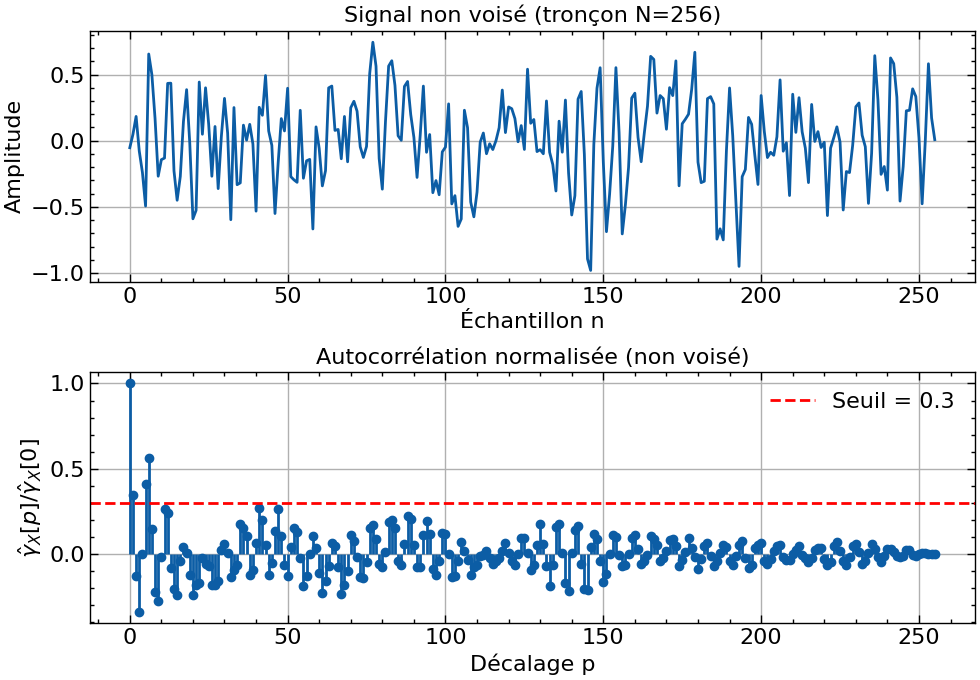

In [19]:
signal_nonvoise, Fe_nv = sf.read('nonvoise_kss.flac')
troncon_nonvoise = signal_nonvoise[:N]

Cx_nonvoise, p_nonvoise = biaisedCrossCorr(troncon_nonvoise, pmax)
Cx_nonvoise_norm = Cx_nonvoise / Cx_nonvoise[0]

peaks_nv, _ = s.find_peaks(Cx_nonvoise_norm[1:])
peaks_nv += 1
peak2_amp_nv = Cx_nonvoise_norm[peaks_nv[0]] if len(peaks_nv) > 0 else 0

print(f"Signal non voisé - amplitude 2e pic : {peak2_amp_nv:.3f}")
print(f"Signal voisé - amplitude 2e pic : {Cx_voise_norm[T0_idx]:.3f}")
print(f"Seuil proposé : 0.3-0.4")

fig, axs = plt.subplots(2, 1, figsize=(10, 7))

axs[0].plot(troncon_nonvoise)
axs[0].set_xlabel('Échantillon n')
axs[0].set_ylabel('Amplitude')
axs[0].set_title('Signal non voisé (tronçon N=256)')
axs[0].grid(True)

axs[1].stem(p_nonvoise, Cx_nonvoise_norm, basefmt=' ')
axs[1].axhline(0.3, color='r', linestyle='--', label='Seuil = 0.3')
axs[1].set_xlabel('Décalage p')
axs[1].set_ylabel(r'$\hat{\gamma}_X[p] / \hat{\gamma}_X[0]$')
axs[1].set_title('Autocorrélation normalisée (non voisé)')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.savefig('figures/signal_nonvoise_autocorr.png', dpi=300, bbox_inches='tight')
plt.show()

Le caractère voisé ou non se caractérise par l'aspect quasi-périodique ou non du signal. Il se voit en comparant l'amplitude du second maximum de la fonction d'autocorrélation au maximum de la fonction d'autocorrélation. 

1. Représenter la fonction d'autocorrélation normalisée par son maximum.
2. À partir de l'étude de plusieurs signaux voisés et non voisés, déterminer un seuil permettant de distinguer les signaux voisés des nons voisés.
3. On écrira la fonction `isvoiced` testant le caractère voisé d'un signal.

In [20]:
print(type(np.array(troncon_voise)))


<class 'numpy.ndarray'>


In [21]:
def isvoiced(X: np.ndarray, threshold: float = 0.3, pmax: int = 100):
    """Determines if a sound is voiced based on its cross correlation values.

    Inputs
    ----------
    X : np.ndarray
        Vector of signal samples

    Returns
    -------
    bool : bool
        1 (true) if the sound is voiced, 0 (false) otherwise.
    """
    Cx, _ = unbiaisedCrossCorr(X, pmax)
    Cx_norm = Cx / Cx[0]
    
    peaks, _ = s.find_peaks(Cx_norm[1:])
    
    if len(peaks) == 0:
        return False
    
    second_peak_amplitude = Cx_norm[peaks[0] + 1]
    
    return second_peak_amplitude > threshold

$\color{blue}\diamond$ <span style="color:blue"> **Checkpoint 6 :** </span> Tester la fonction `isvoiced` sur un signal voisé et sur un signal non voisé.

In [22]:
print("Test de la fonction isvoiced :")
print(f"Signal voisé : {isvoiced(troncon_voise)}")
print(f"Signal non voisé : {isvoiced(troncon_nonvoise)}")

Test de la fonction isvoiced :
Signal voisé : False
Signal non voisé : True


<a id="s1-further"></a>
### Pour aller plus loin

 
- Afin de réduire la complexité, réaliser l'estimateur de la fonction d'autocorrélation à partir d'une DFT et IDFT.  


In [23]:
def autocorr_fft(x: np.ndarray, pmax: int):
    """Calcul rapide de l'autocorrélation via DFT/IDFT (Théorème de Wiener-Khintchine).
    
    Inputs
    ----------
    x : np.ndarray
        Vecteur d'échantillons du signal
    pmax : int
        Décalage maximal à considérer
        
    Returns
    -------
    Cx : np.ndarray
        Vecteur d'autocorrélation pour les décalages 0 à pmax
    p : np.ndarray
        Vecteur des décalages correspondants
    """
    N = len(x)
    x = x - np.mean(x)
    
    x_padded = np.pad(x, (0, N), mode='constant')
    
    X = fft(x_padded)
    S = np.abs(X)**2
    Cx_full = np.real(ifft(S))
    
    Cx = Cx_full[:pmax+1] / N
    p = np.arange(pmax + 1)
    
    return Cx, p

Temps moyen (méthode directe) : 2.423 ms
Temps moyen (méthode FFT)     : 0.209 ms
Accélération : x11.6


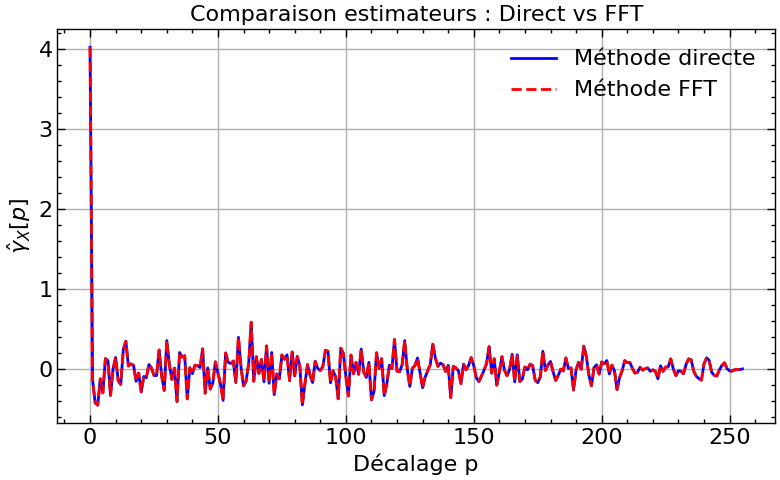

In [24]:
import time

Cx_bb_direct, _ = biaisedCrossCorr(bruit_blanc, pmax)

start = time.time()
for _ in range(100):
    Cx_bb_direct, _ = biaisedCrossCorr(bruit_blanc, pmax)
time_direct = (time.time() - start) / 100

start = time.time()
for _ in range(100):
    Cx_bb_fft, _ = autocorr_fft(bruit_blanc, pmax)
time_fft = (time.time() - start) / 100

print(f"Temps moyen (méthode directe) : {time_direct*1000:.3f} ms")
print(f"Temps moyen (méthode FFT)     : {time_fft*1000:.3f} ms")
print(f"Accélération : x{time_direct/time_fft:.1f}")

fig, ax = plt.subplots(figsize=(8, 5))
p_test = np.arange(pmax + 1)
ax.plot(p_test, Cx_bb_direct, 'b-', label='Méthode directe', linewidth=2)
ax.plot(p_test, Cx_bb_fft, 'r--', label='Méthode FFT', linewidth=2)
ax.set_xlabel('Décalage p')
ax.set_ylabel(r'$\hat{\gamma}_X[p]$')
ax.set_title('Comparaison estimateurs : Direct vs FFT')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.savefig('figures/autocorr_fft_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

***

<a id="seance2"></a>
## Séance 2 : Analyse spectrale

> $\quad$  
> **Objectifs de séance :** 
> - Estimation de la densité spectrale de puissance (DSP) d'un signal
> - Caractérisation d'un processus aléatoire dans le domaine fréquentiel
> - Effet du fenêtrage  
> $\quad$

<a id="s2-estim"></a>
### Deux approches pour un même estimateur (ou presque)

Pour estimer la *densité spectrale de puissance* (DSP) d'un processus $\mathsf{X}$ dont on a mesuré une trajectoire sur un nombre fini $N$ d'échantillons, deux approches sont possibles :  
- **corrélogramme :** utiliser l'estimateur <span style="color:#b10043"> **biaisé** </span> d'autocorrélation (*on pourra essayer avec l'estimateur non biaisé et voir que ça ne fonctionne pas très bien...*) et calculer sa transformée de Fourier
- **périodogramme :** calculer la TFTD des échantillons dont on dispose, prendre la valeur absolue au carré et diviser par le nombre d'échantillons  

Dans la pratique, on ne peut pas estimer à la DSP pour toutes les valeurs de fréquence réduite $\nu$ (car la variable est continue). On s'intéresse donc à la DSP pour un ensemble fini de valeurs de fréquences réduites. Il est intéressant de tirer parti de l'algorithme FFT pour les calculs de transformées de Fourier discrètes, avec un paramètre $N_{fft}$ à choisir.

Ecrire les fonctions réalisant l'estimation de la DSP (une pour chaque méthode) décrites de la manière suivante : 

In [38]:
def psdestimator_corr(X: np.ndarray, Nfft: int):
    """Computation of the PSD estimator using the correlogram method

    Inputs
    ----------
    X : np.ndarray
        Vector of signal samples
    Nfft : int (optional : default len(X)/2)
        Number of signal samples to be considerated in the DFT

    Returns
    -------
    PSD : np.ndarray
        Vector of PSD estimates for normalized frequency
    nu : np.ndarray
        Vector of corresponding normalized frequency values
    """
    N = len(X)
    pmax = min(N - 1, Nfft // 2)
    
    Cx, _ = biaisedCrossCorr(X, pmax)
    
    Cx_sym = np.concatenate([Cx, Cx[-2:0:-1]])
    
    PSD = np.abs(fft(Cx_sym, n=Nfft))
    
    nu = fftfreq(Nfft)
    
    positive_freqs = nu >= 0
    PSD = PSD[positive_freqs]
    nu = nu[positive_freqs]
    
    return PSD, nu

In [39]:
def psdestimator_per(X: np.ndarray, Nfft: int):
    """Computation of the PSD estimator using the periodogram method

    Inputs
    ----------
    X : np.ndarray
        Vector of signal samples
    Nfft : int (optional : default len(X)/2)
        Number of signal samples to be considerated in the DFT

    Returns
    -------
    PSD : np.ndarray
        vector of PSD estimates for normalized frequency
    nu : np.ndarray
        vector of corresponding normalized frequency values
    """
    N = len(X)
    
    X_fft = fft(X, n=Nfft)
    
    PSD = (np.abs(X_fft)**2) / N
    
    nu = fftfreq(Nfft)
    
    positive_freqs = nu >= 0
    PSD = PSD[positive_freqs]
    nu = nu[positive_freqs]
    
    return PSD, nu

$\color{blue}\diamond$ <span style="color:blue"> **Checkpoint 7 :** </span> Tester vos fonctions sur un bruit blanc, un processus $\operatorname{AR}(1)$ et une sinusoïde à phase aléatoire. Discuter les résultats et comparer les résultats des deux méthodes.

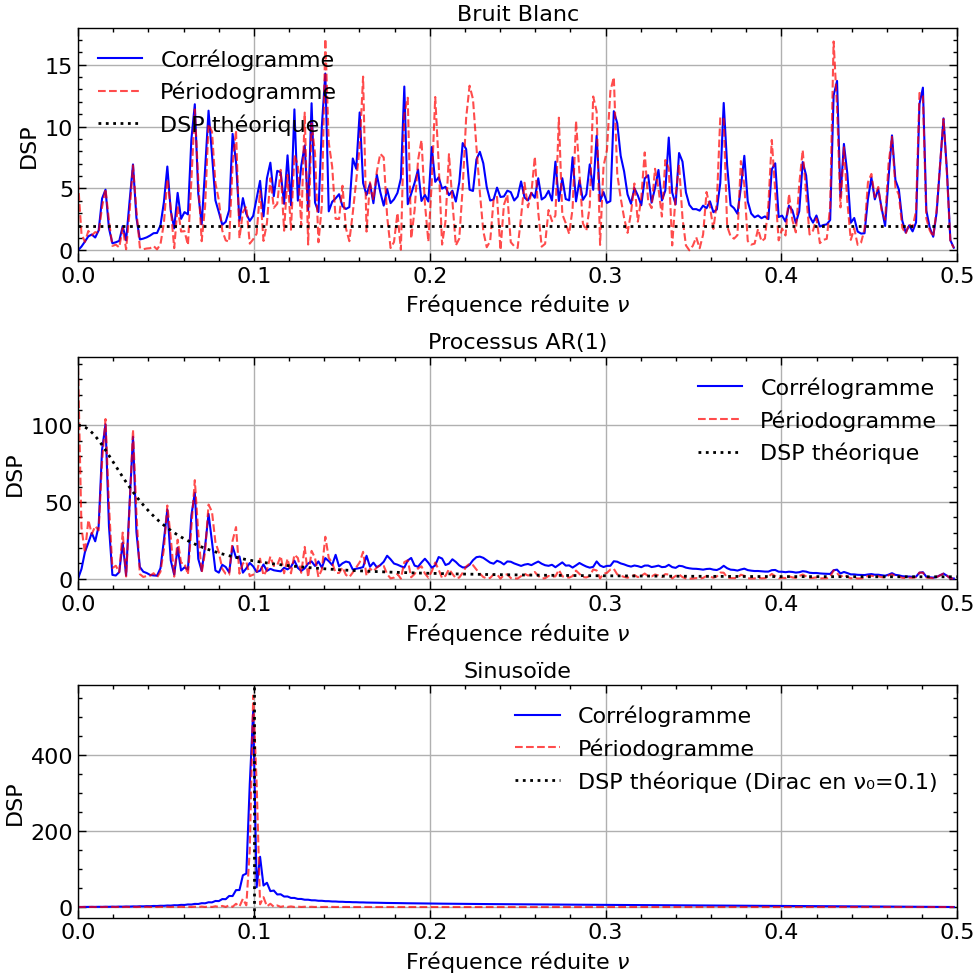

In [40]:
Nfft = 512

PSD_bb_corr, nu_bb_corr = psdestimator_corr(bruit_blanc, Nfft)
PSD_bb_per, nu_bb_per = psdestimator_per(bruit_blanc, Nfft)

PSD_ar_corr, nu_ar_corr = psdestimator_corr(ar1, Nfft)
PSD_ar_per, nu_ar_per = psdestimator_per(ar1, Nfft)

PSD_sin_corr, nu_sin_corr = psdestimator_corr(sinusoide, Nfft)
PSD_sin_per, nu_sin_per = psdestimator_per(sinusoide, Nfft)

nu_theo = np.linspace(0, 0.5, 1000)
PSD_bb_theo = np.ones_like(nu_theo) * sigma_b
PSD_ar_theo = sigma_e**2 / np.abs(1 - a * np.exp(-1j * 2 * np.pi * nu_theo))**2

fig, axs = plt.subplots(3, 1, figsize=(10, 10))

axs[0].plot(nu_bb_corr, PSD_bb_corr, 'b-', label='Corrélogramme', linewidth=1.5)
axs[0].plot(nu_bb_per, PSD_bb_per, 'r--', label='Périodogramme', linewidth=1.5, alpha=0.7)
axs[0].plot(nu_theo, PSD_bb_theo, 'k:', label='DSP théorique', linewidth=2)
axs[0].set_xlabel(r'Fréquence réduite $\nu$')
axs[0].set_ylabel('DSP')
axs[0].set_title('Bruit Blanc')
axs[0].legend()
axs[0].grid(True)
axs[0].set_xlim([0, 0.5])

axs[1].plot(nu_ar_corr, PSD_ar_corr, 'b-', label='Corrélogramme', linewidth=1.5)
axs[1].plot(nu_ar_per, PSD_ar_per, 'r--', label='Périodogramme', linewidth=1.5, alpha=0.7)
axs[1].plot(nu_theo, PSD_ar_theo, 'k:', label='DSP théorique', linewidth=2)
axs[1].set_xlabel(r'Fréquence réduite $\nu$')
axs[1].set_ylabel('DSP')
axs[1].set_title('Processus AR(1)')
axs[1].legend()
axs[1].grid(True)
axs[1].set_xlim([0, 0.5])

axs[2].plot(nu_sin_corr, PSD_sin_corr, 'b-', label='Corrélogramme', linewidth=1.5)
axs[2].plot(nu_sin_per, PSD_sin_per, 'r--', label='Périodogramme', linewidth=1.5, alpha=0.7)
axs[2].axvline(nu_0, color='k', linestyle=':', linewidth=2, label=f'DSP théorique (Dirac en ν₀={nu_0})')
axs[2].set_xlabel(r'Fréquence réduite $\nu$')
axs[2].set_ylabel('DSP')
axs[2].set_title('Sinusoïde')
axs[2].legend()
axs[2].grid(True)
axs[2].set_xlim([0, 0.5])

plt.tight_layout()
plt.savefig('figures/dsp_comparaison_methodes.png', dpi=300, bbox_inches='tight')
plt.show()

Liste non exhaustive des questions que l'on peut se poser :
- Pour la méthode du corrélogramme, quelles valeurs de décalage doit-on prendre en compte ? 
- Pour la méthode du corrélogramme, comment organiser le vecteur de coefficients d'autocorrélation pour que les coefficients calculés par la FFT renvoient une valeur réelle et positive ? 
- Pour la méthode du périodogramme ? Quel nombre d'échantillon doit servir pour la normalisation ? $N$ ou $N_{fft}$ ?
- Quelles sont les fréquences réduites correspondant aux coefficients renvoyés par l'algorithme FFT ?
- Pourquoi peut-on réduire l'affichage à une fréquence réduite comprise entre 0 et 1/2 ? Comment faire ?
- Cet estimateur a-t-il une bonne résolution fréquentielle ? On le testera en prenant comme signal d'entrée la superposition de deux sinusoïdes de fréquences réduites $\nu_1$ et $\nu_2$ très proches.

<a id="s2-wk"></a>
### Fiabilité de l'estimation spectrale

Grâce au théorème de Wiener-Kintchine, on sait que l'estimateur de la DSP est asymptotiquement non biaisé, c'est-à-dire qu'à mesure que le nombre d'échantillon $N$ croît, son espérance s'approche de la véritable DSP.  
Néanmois, à moins que le processus étudié ne soit totalement prédictible (*signaux à très forte structure par exemple*), la variance de l'estimateur de DSP ne converge pas vers zéro quand le nombre d'échantillons croît (il n'y a pas de convergence de l'estimateur en moyenne quadratique).

La seule possibilité pour réduire la variance est alors de tronquer les $N$ échantillons dont on dispose en parts avec lesquelles on estime la DSP et, finalement, moyenner les DSP obtenues. Avec $K$ parties décorrélées, on divise la variance par $K$.

$\color{blue}\diamond$ <span style="color:blue"> **Checkpoint 8 :** </span> Adapter les fonctions d'estimation de la DSP pour qu'elle prenne $K$ en paramètre optionnel et réalise un moyennage le cas échéant.

Liste non exhaustive de questions que l'on peut se poser :
- Comment la variance d'estimation de la DSP d'un bruit blanc évolue-t-elle avec un nombre d'échantillon $N$ croissant ?   
Accord entre théorie et simulation ? 
- Comment la variance d'estimation de la DSP d'un processus $\operatorname{AR}(1)$ évolue-t-elle avec un nombre d'échantillon $N$ croissant ?   
Accord entre théorie et simulation ? 
- Comment la variance d'estimation de la DSP d'une sinusoïde à phase aléatoire évolue-t-elle avec un nombre d'échantillon $N$ croissant ?   
Accord entre théorie et simulation ? 
- Parvient-on à améliorer la variance d'estimation avec un moyennage ? Si oui, quel est le prix à payer ? 

<a id="s2-fenetrage"></a>
### Choix d'une fenêtre temporelle

Selon la nature spectrale du signal observé ou son utilisation, on peut vouloir pondérer les échantillons dont on dispose à l'aide de différentes fenêtres.  
On n'hésitera pas à jeter un oeil à `numpy.window` pour l'implémentation.

| Nom          | $f_N[n]$ pour $n \in [0, N-1]$                                         | Largeur de lobe principal | Pente asymptotique (dB/décade) | Pic secondaire (dB) |
|:--------------:|:----------------------------------------------------------------------:|:----------------------------:|:-------------------------------:|:---------------------:|
| Rectangulaire | $1$                                                                  | $2/N$                      | $-20$                         | $-13.3$             |
| Triangulaire  | $1 - \operatorname{abs}\left(1 - \frac{2n + 1}{N}\right)$                                               | $4/N$                      | $-40$                         | $-26.5$             |
| Hann          | $\frac{1 - \cos(\frac{2\pi n}{N - 1})}{2}$                                   | $4/N$                      | $-60$                         | $-31.5$             |
| Hamming       | $\frac{25}{46} - \frac{21}{46} \cos\left(\frac{2\pi n}{N - 1}\right)$               | $4/N$                      | $-20$                         | $-42.7$             |
| Blackman      | $0.42 - 0.5 \cos\left(\frac{2\pi n}{N - 1}\right) + 0.08 \cos\left(\frac{4\pi n}{N - 1}\right)$     | $6/N$                      | $-60$                         | $-58.1$             |


Liste non exhaustive de questions que l'on peut se poser :
- Quel type de tracé est le plus adéquat pour la représentation de la DSP d’un processus présentant des raies ?
- Quelle fenêtre choisir quand on observe le spectre d’un signal très peu structuré ?
- Comment normaliser les coefficients de la fenêtre pour qu’avec un bruit blanc, on puisse retrouver la valeur de la variance dans la DSP estimée ?
- Quelle fenêtre choisir quand on s’intéresse à la fréquence précise du fondamental d’un son voisé ?
- Quelle fenêtre choisir quand on s’intéresse à l’amplitude d’une harmonique composant un son voisé ? Comment normaliser les coefficients de la fenêtre pour que la hauteur du pic correspondant donne directement l’amplitude ?
- Comment la variance d’estimation de la DSP d’un processus AR1 évolue-t-elle avec un nombre d’échantillons $N$ croissant ? Accord entre théorie et pratique ?
- Comment la variance d’estimation de la DSP d’une sinusoïde à phase aléatoire évolue-t-elle avec un nombre d’échantillons $N$ croissant ? Accord entre théorie et pratique ?
- Peut-on établir un critère fiable basé sur l’estimateur de DSP pour distinguer les sons voisés ? des sons non voisés ? Si oui, que vaut-il par rapport à celui établi sur l’autocorrélation ?

$\color{blue}\diamond$ <span style="color:blue"> **Checkpoint 9 :** </span> Visualiser l'effet de différentes fenêtres sur un signal connu.

***

<a id="seance3"></a>
## Séance 3 : Prédiction linéaire

> $\quad$  
> **Objectifs de séance :** 
> - Mettre en oeuvre la prédiction linéaire afin d'estimer les paramètres d'un modèle source/filtre des sons voisés et non voisés constituant la parole.  
> $\quad$

La prédiction linéaire optimale permet de décorréler les échantillons du signal. Plus précisément, à un ordre $K$, l'erreur de prédiction $e(n,\omega)$ est décorrélée des $K$ derniers échantillons du signal ${X}(n,\omega)$. On espère qu'ainsi, pour des sons vocaux, l'erreur de prédiction puisse fournir une estimation de la *source d'excitation* et que les coefficients optimaux donnent un bon modèle de *filtre*.

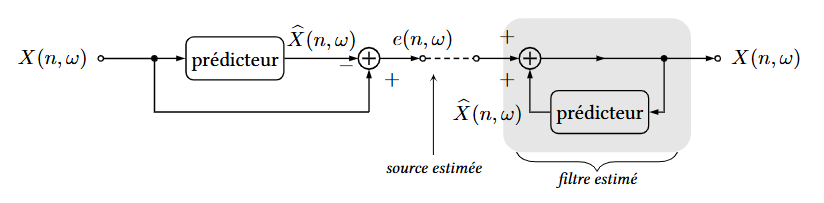

<a id="s3-yule-walker"></a>
### Résolution des équations de Yule-Walker

Ecrire la fonction résolvant le système d'équations de Yule-Walker et décrite de la manière suivante :

In [27]:
def yulewalkersolver(Cx: np.ndarray, K: int):
    """Solve the Yule-Walker equations for a given sequence

    Inputs
    ----------
    X : np.ndarray
        Considered signal
    K : int (optionnal : default len(Cx)-1)
        Order

    Returns
    -------
    a : np.ndarray
        Vector of filter coefficients
    v : float
        Prediction error variance or innovation power
    """
    

**Conseil :** On pourra utiliser la fonction `sp.toeplitz` pour générer la matrice $\Gamma$ à partir du vecteur de termes de l'estimateur biaisé de l'autocorrélation $\hat{\gamma}_{X}$.

<a id="s3-process"></a>
### Réalisations de processus connus

$\color{blue}\diamond$ <span style="color:blue"> **Checkpoint 10 :** </span> Tester la fonction en utilisant directement les *coefficients d'autocorrélation théorique* de processus aléatoires connus (voir Cours ou TD).

Liste non exhaustive de questions que l'on peut se poser :

- Que faire dans la fonction `yulewalkersolver` si le vecteur de termes de l'estimateur $\hat{\gamma}_{X}$ fournit contient moins de $K + 1$ éléments ?
- Avec l’autocorrélation de quel processus connu peut-on tester la fonction à l’ordre $K = 1$ ? Quels coefficients optimaux attend-t-on ?
- Avec l’autocorrélation de quel processus connu peut-on tester la fonction à l’ordre $K = 2$ ? Quels coefficients optimaux attend-t-on ?
- Comment tester le bon fonctionnement de la fonction à un ordre K supérieur ?
- Que se passe-t-il avec un $\operatorname{AR}(1)$ et $K > 1$ ?
- Que se passe-t-il avec une sinusoïde à phase aléatoire et $K > 2$ ?
- Comment évolue la variance d’erreur de prédiction en fonction de l’ordre $K$ ? Pour un processus donné, quel ordre $K$ choisir ?
- Comment le signal prédit se compare-t-il à une réalisation donnée du signal original ?
- Quelle est l’allure de l’autocorrélation de l’erreur de prédiction en fonction du décalage $p$ ? Avec quel processus peut-on modéliser cette erreur ?
- Comment l’autocorrélation d’erreur de prédiction se compare-t-elle à l’autocorrélation du signal ?
- En modélisant le signal par un processus $\operatorname{AR}(K)$ défini par les paramètres fournis par la prédiction linéaire, quelle est l’allure de la DSP estimée ? Dans quelle mesure concorde-t-elle avec la DSP théorique ?

<a id="s3-v-nv"></a>
### Sons voisés et non voisés

$\color{blue}\diamond$ <span style="color:blue"> **Checkpoint 11 :** </span> Reprendre l'étude précédente avec les sons voisés et non voisés fournis.

Liste non exhaustive de questions que l’on peut se poser :
- À quel ordre $K$ semble-t-il raisonnable de limiter la prédiction linéaire pour les sons voisés ? Pour les sons non voisés ?
- Selon le caractère voisé du signal, quelle est l’allure de l’autocorrélation de l’erreur de prédiction en fonction du décalage $p$ ? Avec quel processus peut-on modéliser ces erreurs ?
- Comment les estimations spectrales paramétriques se comparent-elles à celles non paramétriques réalisées lors de la séance précédente ?

Finalement, disposant de modèles de filtres et de processus d’excitation, **nous sommes en mesure de générer des sons voisés et non voisés synthétiques**.   
À partir des caractéristiques extraites des sons fournis, générer des sons synthétiques sur des durées de plusieurs secondes et vérifier la qualité sonore de cette synthèse.

***

<a id="seance4"></a>
## Séance 4 : Codage (compression), décodage et effets sur la parole

> $\quad$  
> **Objectifs de séance :** 
> - Mettre en oeuvre le codage/décodage du signal de parole par prédiciton linéaire en traitant le signal par tronçon.
> - Comparaison des signaux synthétiques et réels avec les outils de traitement du signal (autocorrélation, spectre) et à l'oreille.
> - Application d'effet sur la voix par modification des caractéristiques analysées sur les tronçons.  
> $\quad$

Il s’agit maintenant de rassembler des différents outils développés lors des séances précédentes de manière à analyser et synthétiser des signaux vocaux de longue durée.   
Si vous avez rencontré des diffcultés avec l’implémentation de certaines fonctions, il est possible, dans une certaine mesure de s’en affranchir.   
Le tableau suivant montre les équivalences avec des fonctions de base.

| Estimateur        |     Code réalisé          | Fonctions toutes faites de référence   |
|:-----------------:|:-------------------------:|:--------------------------------------:|
| Autocorrélation   | [un]biasedcrosscorr       |                      `numpy.correlate` |
|     Spectre       |        psdestimator       |                   `scipy.signal.welch` |
|     Filtre de prédiction       |        yulewalkersolver       |                   `librosa.lpc` |
| Pitch             |  isvoiced                 |  `librosa.pyin`|

<a id="s4-analyse"></a>
### Analyse d'un tronçon

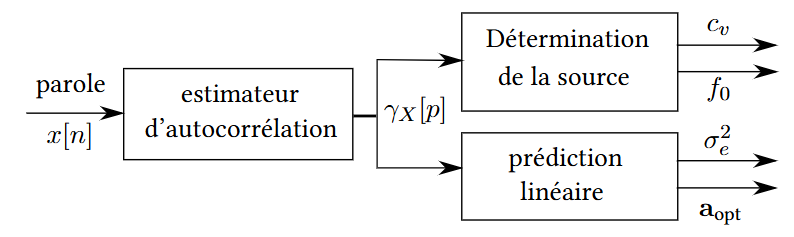

Après avoir écrit un fonction permettant d'obtenir le pitch d'un signal voisé, écrire la fonction permettant d'analyser un tronçon de signal de $256$ échantillons, décrite de la manière suivante :

In [28]:
def pitchdetector(
    X: np.ndarray, Fe: float = 10_000, Fmin: float = 100, Fmax: float = 400
):
    """Determine the pitch of a signal based on its cross-correlation

    Inputs
    ----------
    X : np.ndarray
        Vector of signal samples
    Fe : float, optional
        Sampling rate, by default 10_000
    Fmin : float, optional
        Minimal pitch, by default 100
    Fmax : float, optional
        Maximal pitch, by default 400

    Returns
    -------
    pitch : float
        The pitch value in normalized frequency if the sound is voiced, -1 otherwise
    """

In [29]:
def blockanalysis(X: np.ndarray, M: int = 10, Fe: float = 10_000):
    """Analyses the samples of a supposedly stationnary process and fits the parameters of a model source/filter

    Inputs
    ----------
    X : np.ndarray
        Vector of samples of the current block of signal
    M : int, optional
        Filter order, by default 10
    Fe : float, optional
        Sampling frequency, by default 10_000

    Returns
    -------
    pitch : float
        The pitch value in normalized frequency if the sound is voiced, -1 overwise
    sigma2 : float
        The variance of excitation
    Aopt : np.ndarray
        Vector of filter coefficients (optimal prediction of order M)
    """

<a id="s4-synthese"></a>
### Synthèse d'un tronçon

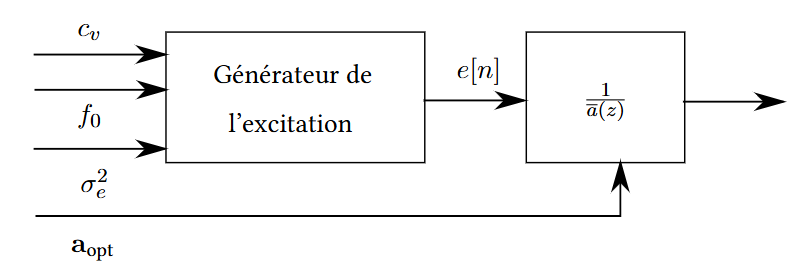

Ecrire la fonction permettant de synthétiser un tronçon de signal, décrite de la manière suivante :

In [30]:
def blocksynthesis(pitch: float, sigma2: float, Aopt: np.ndarray, N: int):
    """Analyses the samples of a supposedly stationnary process and fits the parameters of a model source/filter

    Parameters
    ----------
    pitch : float
        The pitch value in normalized frequency if the sound is voiced, -1 overwise
    sigma2 : float
        The variance of excitation
    Aopt : np.ndarray
        Vector of filter coefficients (optimal prediction of order M)
    N : int
        Number of samples to be synthetized

    Returns
    -------
    Y : np.ndarray
        Synthetized block
    """

$\color{blue}\diamond$ <span style="color:blue"> **Checkpoint 12 :** </span> Tester les fonctions précédentes pour un signal connu en comparant la reconstruction avec le signal de départ (en terme d'autocorrélation ou de DSP)

<a id="s4-tns-effets"></a>
### Traitement d'un signal et effets

Commencez par écrire un script chargeant un signal sonore, l'analysant par tronçons puis synthétisant de nouveaux tronçons à partir des caractéristiques extraites. 

$\color{blue}\diamond$ <span style="color:blue"> **Checkpoint 13 :** </span> Après avoir découpé le signal en tronçons, réaliser la sythèse de l'ensemble des tronçons et les assembler. Que peut-on dire de la qualité du signal produit ? 

**Conseil :** Si les tronçons sont contigus sans recouvrement, les variations de puissances rapides en passant d'un tronçon à l'autre perturbent la qualité d'écoute. Pour pallier ce problème, on peut utiliser des tronçons pondérés par une fenêtre de Hann avec un recouvrement de 50%

<b> Effets que l'on peut envisager :</b>  
- Changement de tonalité sans changement de durée
- Passage à une voix chuchotée (bruit blanc pour l'excitation)
- Voix robotique (impulsion périodique pour l'excitation avec un fondamental fixe, indépendamment du signal analysé)
- Remplacement de l'excitation par une piste instrumentale